In [1]:
import numpy as np
import networkx as nx
from scipy.linalg import block_diag

from specializeGraph import *

# Incoming and Outgoing Link Specialization

* Development of the algorithm and a few tests.
* Timing the speed
* Looking for exmples of changes in spectral radius

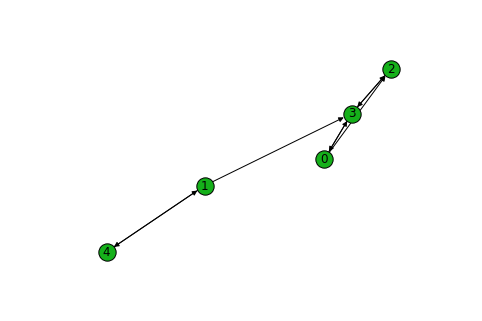

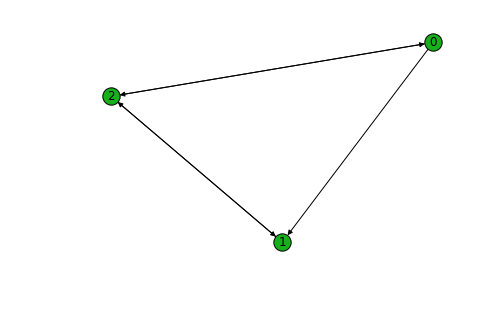

In [2]:
A = np.array([   [ 0,  0., 0., 0., 1.],
                 [ 0., 0., 0., 1., 0.],
                 [ 0., 1., 0., 1., 0.],
                 [ 1., 1., 1., 0., 0],
                 [ 1., 0., 0., 0., 0.]])
A = baseFirst(A,[1])
drawGraph(A)
bSize=1
smA,comp = compressGraph(A,1)
drawGraph(delSink(A.T,1,comp)[0].T)

In [2]:

def outSpecialize(A,base):
    
    if np.diag(A).sum() != 0:
        raise ValueError("Some vertices have self edges")

    n = A.shape[0]

    #Permute A so that the base nodes come first
    A = baseFirst(A,base)
    bSize = len(base)


    #Find connected components and compress graph
    smA,comp = compressGraph(A,bSize)   

    #Remove all sink components
    A,comp = delSink(A,bSize,comp=comp)
    
    #OUTDEGREE METHOD
    S = A.copy()
    moreLinks = True
    while moreLinks:
        moreLinks = False
        #Check the out-degree of each component
        for key in comp.keys():
            if comp[key][0] >= bSize:
                outDeg = S[:,comp[key]].sum() - S[comp[key]][:,comp[key]].sum()
                #If the out-degree is greater than 1, specialize the component
                if outDeg > 1:
                    moreLinks = True
                    n = S.shape[0]
                    otherNodes = list(set(range(n)).difference(set(comp[key])))
                    #Find all outgoing links
                    links = findLinks(S,comp[key],otherNodes)
                    for i in range(1,len(links)):
                        n = S.shape[0]
                        S = outSplzLink(S,bSize,links[i],links[i][1],comp[key])
                        #Add the new component to the component dictionary
                        comp[max(comp.keys())+1] = np.arange(n,n+len(comp[key]))
                        #Recompute out-degree if necessary
    
    #PATH METHOD
    """
    #Find all paths from a base node to a base node
    #through the connected components
    pressedPaths = findPathsToBase(smA,bSize)

    #Begin creating the block diagonal of specialized matrix
    S = A.copy()

    #For each compressed path
    nNodes = bSize
    for Path in pressedPaths:
        compnts = [comp[c] for c in Path]
        pastSize = S.shape[0]
        #Traverse the path backwards
        for i in range(1,len(compnts)):
            curSize = S.shape[0]
            #Find links between the current component and 
            #all copies of it's neighbor
            tail = compnts[-i-1]
            tip = list(compnts[-i])+list(range(pastSize,curSize))

            links = findLinks(S,tail,tip)
            #specialize each link
            pastSize = S.shape[0]
            for link in links:
                S = outSplzLink(S,bSize,link,link[1],compnts[-i-1])
    """
    return S

def inSpecialize(A,base):
    return outSpecialize(A.T,base).T

def findLinks(A,tail,tip):
    n = A.shape[0]

    rows = tip*len(tail)
    cols = []
    for c in tail:
        cols += [c]*len(tip)

    B = np.zeros_like(A)
    B[rows,cols] = A[rows,cols]

    #Find links
    linkRows,linkCols = np.where(B==1)
    links = zip(linkRows,linkCols)
    return links

def outSplzLink(A,bSize,edge,node,comp):
    
    #If the node being copied is in the base
    #return A unchanged
    if edge[1] < bSize:
        return A
    
    #If there is only one outgoing link from the component
    #return A unchanged
    if A[:,comp].sum() - A[comp][:,comp].sum() == 1:
        return A
        
    #Find sizes and locations
    whichNode = np.where(comp==node)[0]
    CLen = len(comp)
    n = A.shape[0]
    
    #Add the new component to the graph
    sA = block_diag(A,A[comp][:,comp])
    
    #Create new edge running from the copied component
    #to the graph
    newEdge = edge[0],n+whichNode
    
    sA[newEdge] = 1
    #Delete the old edge
    sA[edge] = 0

    
    #Keep all incoming edges
    keptLinks = A[comp,:]
    #Remove old intercomponent edges
    keptLinks[:,comp] = np.zeros((CLen,CLen))
    sA[-CLen:,:-CLen] = keptLinks
    
    return sA

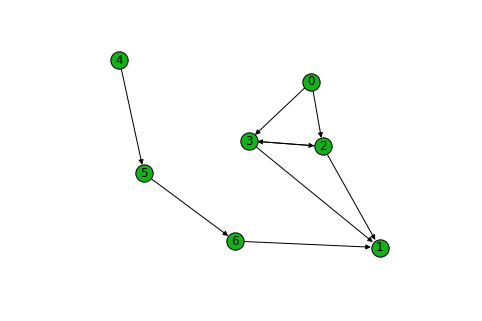

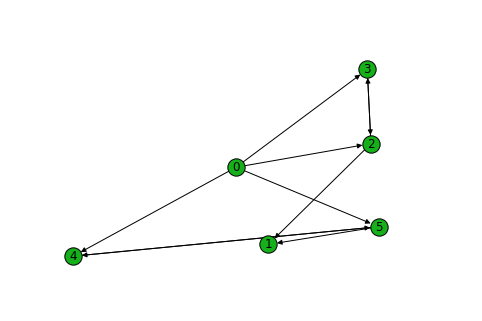

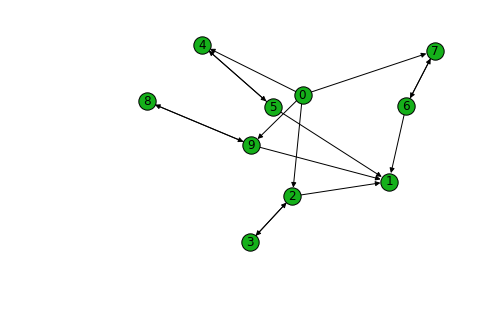

In [4]:
A = np.array([[0,0,0,0,0,0,0],
              [0,0,1,1,0,0,1],
              [1,0,0,1,0,0,0],
              [1,0,1,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,1,0,0],
              [0,0,0,0,0,1,0]
])

drawGraph(A)
sA = outSpecialize(A,[0,1])
drawGraph(sA)
sA = inSpecialize(sA,[0,1])
drawGraph(sA)

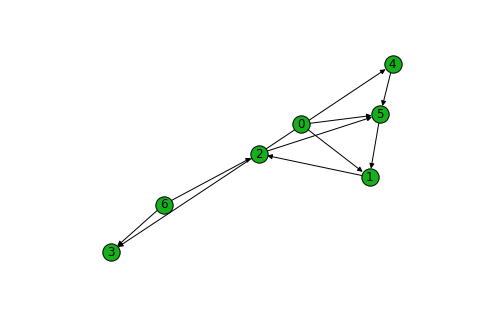

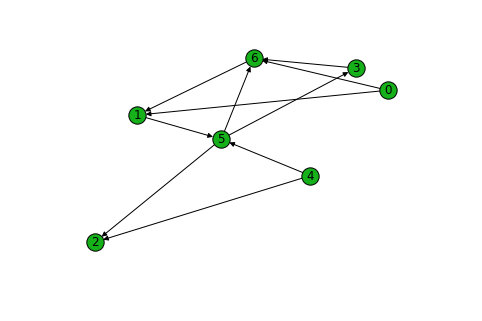

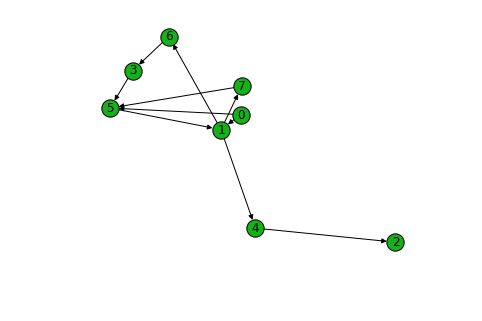

(1.4604763328424841+0j)
(1.529248956345962+0j)


In [14]:
A = np.array([[0,0,0,0,0,0,0],
              [1,0,0,0,0,1,0],
              [0,1,0,0,0,0,1],
              [0,0,1,0,0,0,1],
              [0,0,1,0,0,0,0],
              [1,0,1,0,1,0,0],
              [0,0,0,0,0,0,0]
             ])
drawGraph(A)
A = baseFirst(A,[0,1,3,4,6])
drawGraph(A)
sA = outSpecialize(A,[0,1,2])
drawGraph(sA)
print(spectralRad(laplacian(A,randomWalk=True)))
print(spectralRad(laplacian(sA,randomWalk=True)))

In [42]:
A = np.array([[0,0,1,1,0,0,1],
              [1,0,0,0,0,1,1],
              [0,1,0,0,0,0,1],
              [0,1,0,0,0,1,0],
              [1,1,1,1,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0]
             ])
print(spectralRad(laplacian(A,randomWalk=True)))
print(spectralRad(laplacian(specializeGraph(A,[0,2,3]),randomWalk=True)))
print(spectralRad(laplacian(specializeGraph(A,[0,2,3,4,5,6]),randomWalk=True)))

(1.3083846076565855+0j)
(1.7320508075688767+0j)
(1.3613135716240397+0j)


### Time the two algorithms

In [17]:
import time
from matplotlib import pyplot as plt

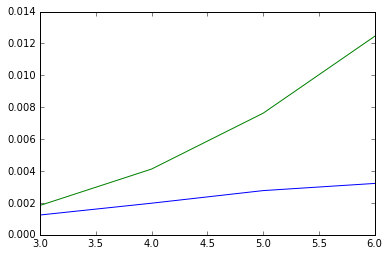

In [18]:
x = np.arange(3,7)
yLink = []
yGraph = []
for n in range(3,7):
    linkSp = 0
    graphSp = 0
    for i in range(3):
        A = (np.random.rand(n,n)>np.random.rand())*1.
        for j in range(n): A[j,j] = 0
        nodes = list(range(n))
        base = list(np.random.choice(nodes,replace=False,size=np.random.randint(1,high=n)))
        bSize = len(base)
        
        t0 = time.time()
        sA = inSpecialize(outSpecialize(A,base),list(range(bSize)))
        t1 = time.time()
        linkSp+= t1-t0
        
        t0 = time.time()
        sA = specializeGraph(A,base)
        t1 = time.time()
        graphSp+= t1-t0
    
    yLink.append(linkSp/3.)
    yGraph.append(graphSp/3.)

plt.plot(x,yGraph)
plt.plot(x,yLink)
plt.show()

### A look at how out-degree specialization affects the laplacian

Both the normalized laplacian and laplacian are not affected by out degree specialization except for in a few cases. We will examine these more closely

/Library/Python/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
/Library/Python/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: ComplexWarning: Casting complex values to real discards the imaginary part


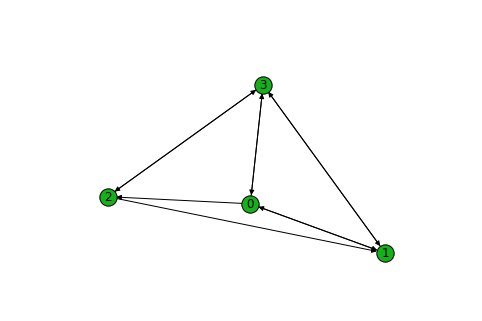

[0, 1]


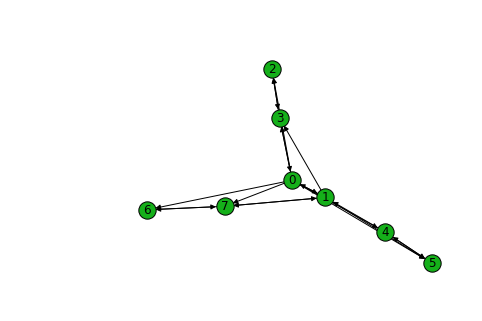

L: 
[[ 1.         -0.5         0.         -0.5       ]
 [-0.33333333  1.         -0.33333333 -0.33333333]
 [-0.5         0.          1.         -0.5       ]
 [-0.33333333 -0.33333333 -0.33333333  1.        ]]
sL: 
[[ 1.         -0.5         0.         -0.5         0.          0.
   0.          0.        ]
 [-0.33333333  1.          0.          0.         -0.33333333  0.
   0.         -0.33333333]
 [-0.5         0.          1.         -0.5         0.          0.
   0.          0.        ]
 [-0.33333333 -0.33333333 -0.33333333  1.          0.          0.
   0.          0.        ]
 [-0.5         0.          0.          0.          1.         -0.5
   0.          0.        ]
 [-0.33333333 -0.33333333  0.          0.         -0.33333333  1.
   0.          0.        ]
 [-0.5         0.          0.          0.          0.          0.
   1.         -0.5       ]
 [-0.33333333 -0.33333333  0.          0.          0.          0.
  -0.33333333  1.        ]]
SPECTRUM: 
rL: 1.354
SPECIAL SPECTRUM: 


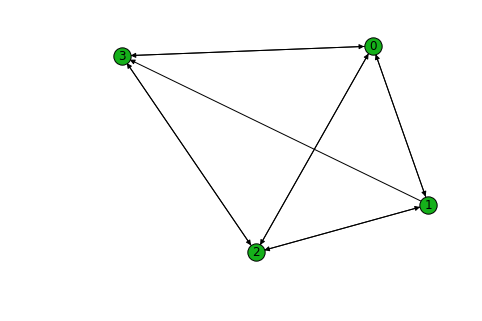

[3, 2]


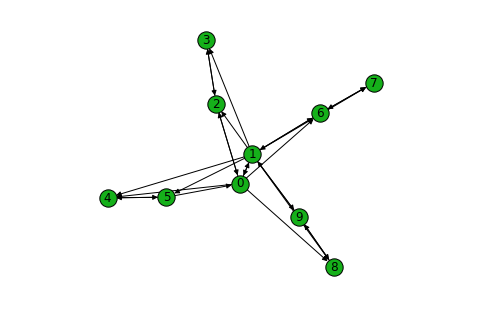

L: 
[[ 1.         -0.33333333 -0.33333333 -0.33333333]
 [-0.5         1.         -0.5         0.        ]
 [-0.33333333 -0.33333333  1.         -0.33333333]
 [-0.33333333 -0.33333333 -0.33333333  1.        ]]
sL: 
[[ 1.         -0.33333333 -0.33333333  0.          0.         -0.33333333
   0.          0.          0.          0.        ]
 [-0.33333333  1.          0.          0.          0.          0.
  -0.33333333  0.          0.         -0.33333333]
 [-0.33333333 -0.33333333  1.         -0.33333333  0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -0.5        -0.5         1.          0.          0.
   0.          0.          0.          0.        ]
 [-0.33333333 -0.33333333  0.          0.          1.         -0.33333333
   0.          0.          0.          0.        ]
 [ 0.         -0.5         0.          0.         -0.5         1.
   0.          0.          0.          0.        ]
 [-0.33333333 -0.33333333  0.          0.          0.          0.
  

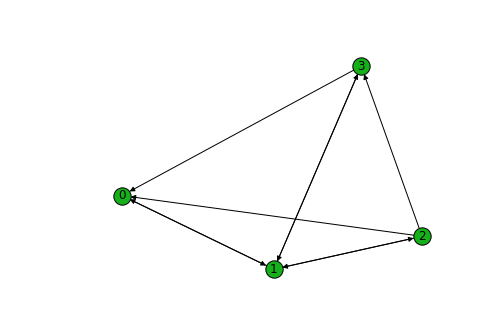

[0, 3]


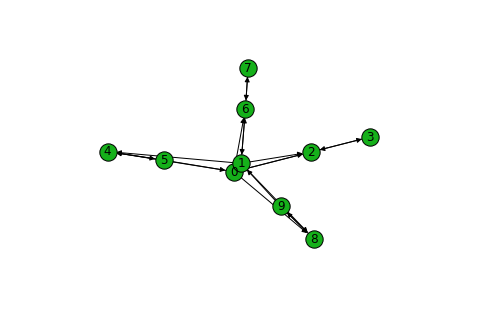

L: 
[[ 1.         -0.33333333 -0.33333333 -0.33333333]
 [-0.33333333  1.         -0.33333333 -0.33333333]
 [ 0.         -1.          1.          0.        ]
 [ 0.         -0.5        -0.5         1.        ]]
sL: 
[[ 1.         -0.33333333 -0.33333333  0.          0.         -0.33333333
   0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.
  -0.5         0.          0.         -0.5       ]
 [-0.33333333 -0.33333333  1.         -0.33333333  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -1.          1.          0.          0.
   0.          0.          0.          0.        ]
 [-0.33333333 -0.33333333  0.          0.          1.         -0.33333333
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -1.          1.
   0.          0.          0.          0.        ]
 [-0.33333333 -0.33333333  0.          0.          0.          0.
  

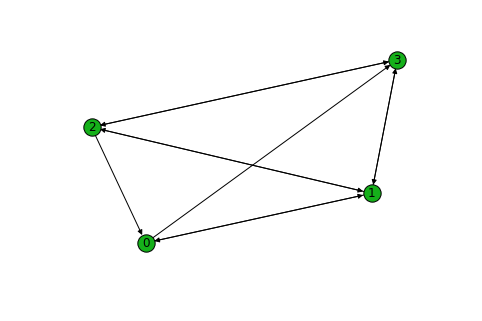

[3, 2]


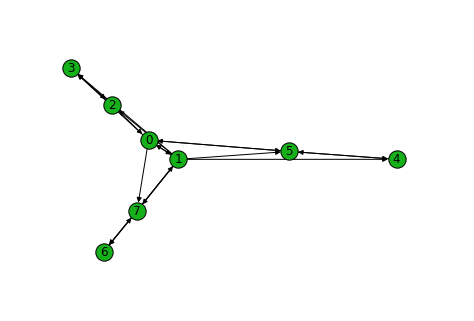

L: 
[[ 1.         -0.5        -0.5         0.        ]
 [-0.33333333  1.         -0.33333333 -0.33333333]
 [ 0.         -0.5         1.         -0.5       ]
 [-0.33333333 -0.33333333 -0.33333333  1.        ]]
sL: 
[[ 1.         -0.33333333 -0.33333333  0.          0.         -0.33333333
   0.          0.        ]
 [-0.5         1.          0.          0.          0.          0.
   0.         -0.5       ]
 [ 0.         -0.5         1.         -0.5         0.          0.
   0.          0.        ]
 [-0.33333333 -0.33333333 -0.33333333  1.          0.          0.
   0.          0.        ]
 [ 0.         -0.5         0.          0.          1.         -0.5
   0.          0.        ]
 [-0.33333333 -0.33333333  0.          0.         -0.33333333  1.
   0.          0.        ]
 [ 0.         -0.5         0.          0.          0.          0.
   1.         -0.5       ]
 [-0.33333333 -0.33333333  0.          0.          0.          0.
  -0.33333333  1.        ]]
SPECTRUM: 
rL: 1.354
SPECIAL SPE

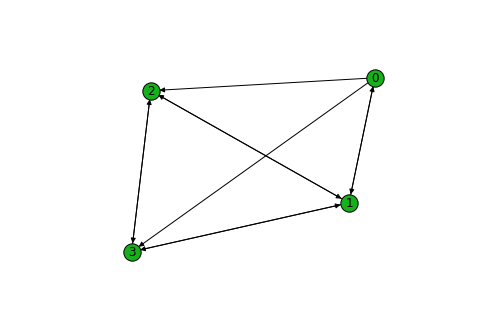

[2]


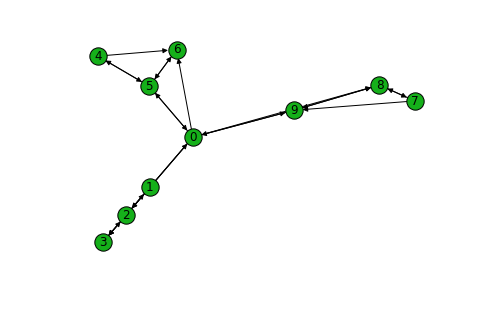

L: 
[[ 1.         -1.          0.          0.        ]
 [-0.33333333  1.         -0.33333333 -0.33333333]
 [-0.33333333 -0.33333333  1.         -0.33333333]
 [-0.33333333 -0.33333333 -0.33333333  1.        ]]
sL: 
[[ 1.         -0.33333333  0.          0.          0.         -0.33333333
   0.          0.          0.         -0.33333333]
 [ 0.          1.         -1.          0.          0.          0.
   0.          0.          0.          0.        ]
 [-0.33333333 -0.33333333  1.         -0.33333333  0.          0.
   0.          0.          0.          0.        ]
 [-0.33333333 -0.33333333 -0.33333333  1.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.         -1.
   0.          0.          0.          0.        ]
 [-0.33333333  0.          0.          0.         -0.33333333  1.
  -0.33333333  0.          0.          0.        ]
 [-0.33333333  0.          0.          0.         -0.33333333 -0.33333333
  

In [28]:
n = 4
for i in range(100):
    A = (np.random.rand(n,n)>np.random.rand())*1.
    for j in range(n): A[j,j] = 0
    nodes = list(range(n))
    base = list(np.random.choice(nodes,replace=False,size=np.random.randint(1,high=n)))
    L = laplacian(A,randomWalk=1)
    rL = round(spectralRad(L),3)

    
    sA = outSpecialize(A,base)
    sL = laplacian(sA,randomWalk=1)
    SrL = round(spectralRad(sL),3)
    if SrL != rL and sA.shape[0] > A.shape[0]:
        drawGraph(A)
        print(base)
        drawGraph(sA)
        print("L: ")
        print(L)
        print("sL: ")
        print(sL)
        print("SPECTRUM: \nrL: {}".format(rL) )
        print("SPECIAL SPECTRUM: \nSrL: {}".format(SrL) )
        print("\n")

/Library/Python/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part


[2]
[[0. 1. 0. 0.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


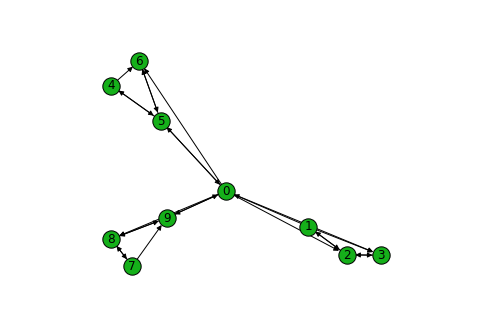

/Library/Python/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: ComplexWarning: Casting complex values to real discards the imaginary part


In [19]:
n = 4
for i in range(10):
    A = (np.random.rand(n,n)>np.random.rand())*1.
    for j in range(n): A[j,j] = 0
    nodes = list(range(n))
    base = list(np.random.choice(nodes,replace=False,size=np.random.randint(1,high=n)))
    rL = round(spectralRad(laplacian(A,randomWalk=1)),3)
    sA = outSpecialize(A,base)
    SrL = round(spectralRad(laplacian(sA,randomWalk=1)),3)
    if rL < SrL:
        print(base)
        print(A)
        drawGraph(sA)

In [ ]:
A = np.array([[0,0,0,0]])

Does the undirected lapacian ever increase in radius when you remove edges?
Simplest examples of change in radius
rho <= max deg(y)+deg(x) for all nodes x,y that are connected